In [286]:
import boto3
import sagemaker
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.tensorflow import TensorFlow
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import load_img
from sagemaker import get_execution_role

### Collecting data, inspecting the data and splitting into train and val

I uploaded a generated kaggle.json API token to download the dataset directly from Kaggle.

Now i will install kaggle and kaggle-cli, create the directory to kaggle and configure the token.

After that i will download the dataset and unzip the files. 

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset
!kaggle datasets download -d "phylake1337/fire-dataset" 

 99%|████████████████████████████████████████▋| 384M/387M [00:04<00:00, 101MB/s]
100%|████████████████████████████████████████| 387M/387M [00:04<00:00, 94.8MB/s]


In [4]:
# Unzip files
!unzip 'fire-dataset.zip'

Archive:  fire-dataset.zip
  inflating: fire_dataset/fire_images/fire.1.png  
  inflating: fire_dataset/fire_images/fire.10.png  
  inflating: fire_dataset/fire_images/fire.100.png  
  inflating: fire_dataset/fire_images/fire.101.png  
  inflating: fire_dataset/fire_images/fire.102.png  
  inflating: fire_dataset/fire_images/fire.103.png  
  inflating: fire_dataset/fire_images/fire.104.png  
  inflating: fire_dataset/fire_images/fire.105.png  
  inflating: fire_dataset/fire_images/fire.106.png  
  inflating: fire_dataset/fire_images/fire.107.png  
  inflating: fire_dataset/fire_images/fire.108.png  
  inflating: fire_dataset/fire_images/fire.109.png  
  inflating: fire_dataset/fire_images/fire.11.png  
  inflating: fire_dataset/fire_images/fire.110.png  
  inflating: fire_dataset/fire_images/fire.111.png  
  inflating: fire_dataset/fire_images/fire.112.png  
  inflating: fire_dataset/fire_images/fire.113.png  
  inflating: fire_dataset/fire_images/fire.114.png  
  inflating: fire_datas

In [5]:
# Verifying the content of the file unziped
os.listdir('fire_dataset')\

['fire_images', 'non_fire_images']

Fire files : 755 
Non fire files:  244


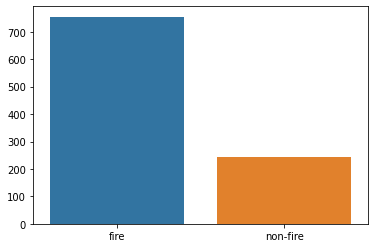

In [276]:
# Plot of classes in the dataset
print('Fire files :', len(fire_files), '\nNon fire files: ',len(nfire_files))
sns.barplot(x=['fire', 'non-fire'], y = [len(fire_files), len(nfire_files)]);

In [293]:
# We can see the descritive statistic of the pixels from each class 
mean_1 = []
median_1 = []
min_1 = []
max_1 = []
std_1 = []
shape = []

for files in fire_files:
    array = np.asarray(Image.open("fire_dataset/fire_images/{}".format(files)))
    mean_1.append(np.mean(array))
    median_1.append(np.median(array))
    min_1.append(np.min(array))
    max_1.append(np.max(array))
    std_1.append(np.std(array))
    shape.append(array.shape)

mean_2 = []
median_2 = []
min_2 = []
max_2 = []
std_2 = []

for files in nfire_files:
    array = np.asarray(Image.open("fire_dataset/non_fire_images/{}".format(files)))
    mean_2.append(np.mean(array))
    median_2.append(np.median(array))
    min_2.append(np.min(array))
    max_2.append(np.max(array))
    std_2.append(np.std(array))
    shape.append(array.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


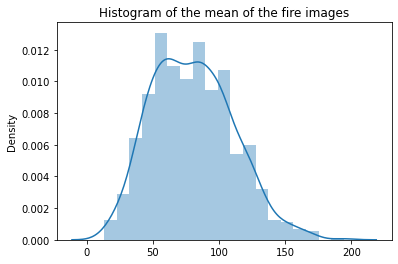

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


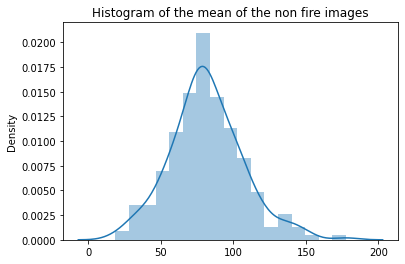

In [294]:
sns.distplot(mean_1)
plt.title('Histogram of the mean of the fire images')
plt.show()
sns.distplot(mean_2)
plt.title('Histogram of the mean of the non fire images')
plt.show()

In [295]:
pd.DataFrame({'Mean':[np.mean(mean_1), np.mean(mean_2)],
             'Median':[np.mean(median_1), np.mean(median_2)],
             'Min': [np.mean(min_1), np.mean(min_2)],
             'Max': [np.mean(max_1), np.mean(max_2)],
             'Std':[np.mean(std_1), np.mean(std_2)]}, index=['Fire', 'Non-fire'])

,Mean,Median,Min,Max,Std
Fire,80.023530,61.684768,0.369536,254.981457,62.981823
Non-fire,81.651768,70.270492,0.196721,251.856557,56.423184


In [307]:
print('Smallest image: ', np.min(shape))
print('Biggest image: ', np.max(shape))
print('Mean size of the images: ', (int(np.mean(shape[0])), int(np.mean(shape[1])), 3))

Smallest image:  (147, 220, 3)
Biggest image:  (4608, 6144, 3)
Mean size of the images:  (261, 357, 3)


### Visualizing some of the training data

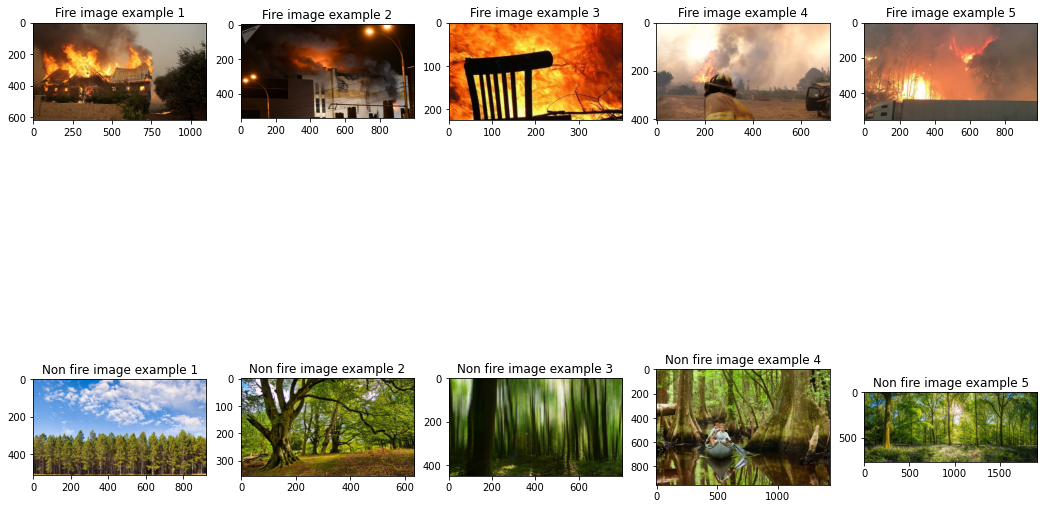

In [5]:
# Getting 5 random samples from each train folder 

random_fire = random.sample(fire_files, 5)
random_non_fire = random.sample(nfire_files, 5)

fig, ax = plt.subplots(2,5, figsize=(18,12))
for i, u in enumerate(zip(random_fire, random_non_fire)):
    ax[0,i].set_title('Fire image example {}'.format(i+1))
    ax[0, i].imshow(np.asarray(Image.open("fire_dataset/fire_images/{}".format(u[0]))))
    ax[1,i].set_title('Non fire image example {}'.format(i+1))
    ax[1, i].imshow(np.asarray(Image.open("fire_dataset/non_fire_images/{}".format(u[1]))))
    

### Splitting the dataset to train and val into 90/10 ratio. 

In [33]:
# Installing a lib to split the dataset into train and val folders
!pip install split-folders

In [88]:
import splitfolders
splitfolders.ratio("fire_dataset", output="fire_dataset_split", seed=42, ratio=(.7, .2, 0.1)) 

In [89]:
# Verifying the results

# Getting the files in each folder and subfolder
train_fire = os.listdir('fire_dataset_split/train/fire_images')
train_non_fire = os.listdir('fire_dataset_split/train/non_fire_images')
val_fire = os.listdir('fire_dataset_split/val/fire_images')
val_non_fire = os.listdir('fire_dataset_split/val/non_fire_images')
test_fire = os.listdir('fire_dataset_split/test/fire_images')
test_non_fire = os.listdir('fire_dataset_split/test/non_fire_images')


print('Content of fire_dataset_split folder: ', os.listdir('fire_dataset_split'))
print('Train has {} fire files and {} non fire files.'.format(len(train_fire), len(train_non_fire)))
print('Val has {} fire files and {} non fire files.'.format(len(val_fire), len(val_non_fire)))
print('Test has {} fire files and {} non fire files.'.format(len(test_fire), len(test_non_fire)))

Content of fire_dataset_split folder:  ['train', 'test', 'val']
Train has 528 fire files and 170 non fire files.
Val has 151 fire files and 48 non fire files.
Test has 76 fire files and 26 non fire files.


### Upload data to S3

In [90]:
role = get_execution_role()
bucket = sagemaker.Session().default_bucket()

def upload_to_s3(bucket, channel, path):
    s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                      path=path, 
                                                      key_prefix=channel)

In [91]:
# Data copy to s3
s3_train_key = "fire_dataset_split/train"
s3_validation_key = "fire_dataset_split/val"
s3_test_key = "fire_dataset_split/test"


# upload all data to S3
upload_to_s3(bucket, s3_train_key, s3_train_key)
upload_to_s3(bucket, s3_validation_key, s3_validation_key)
upload_to_s3(bucket, s3_test_key, s3_test_key)

In [92]:
# confirm that data is in S3 bucket
empty_check = []
count = 0
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    count+=1

print('Number of files: ', count)
assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Number of files:  1468
Test passed!


### Create a simple CNN model to classify the images

In [207]:
train_input_path = "s3://{}/{}".format(bucket, s3_train_key)
validation_input_path = "s3://{}/{}".format(bucket, s3_validation_key)

tf_version = tf.__version__
tf_version

estimator = TensorFlow(
  entry_point="train_cnn.py",    # My entry script
  role=role,
  train_instance_count=1, # "The number of GPUs instances to use"
  train_instance_type='ml.p2.xlarge',  
  framework_version=tf_version,
  py_version="py3",
  script_mode = True,
  hyperparameters={'epochs': 30}
)

print("Training ...")
estimator.fit({'train': train_input_path, 'eval': validation_input_path})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Training ...
2021-04-13 12:08:33 Starting - Starting the training job...
2021-04-13 12:08:56 Starting - Launching requested ML instancesProfilerReport-1618315712: InProgress
......
2021-04-13 12:09:57 Starting - Preparing the instances for training.........
2021-04-13 12:11:17 Downloading - Downloading input data...
2021-04-13 12:11:57 Training - Downloading the training image......
2021-04-13 12:12:57 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-04-13 12:12:49,389 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-04-13 12:12:50,005 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
   

### Deploy model and evaluate

In [208]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------------!

In [217]:
def img_to_input(url, predictor):
    
    # Resize as model was trained after resizing
    test_image = load_img(url, target_size=(160, 160))
    test_image_array = np.array(test_image).reshape((1, 160, 160, 3)).tolist()

    # Predict
    label = np.argmax(predictor.predict(test_image_array)['predictions'][0])
    
    return label

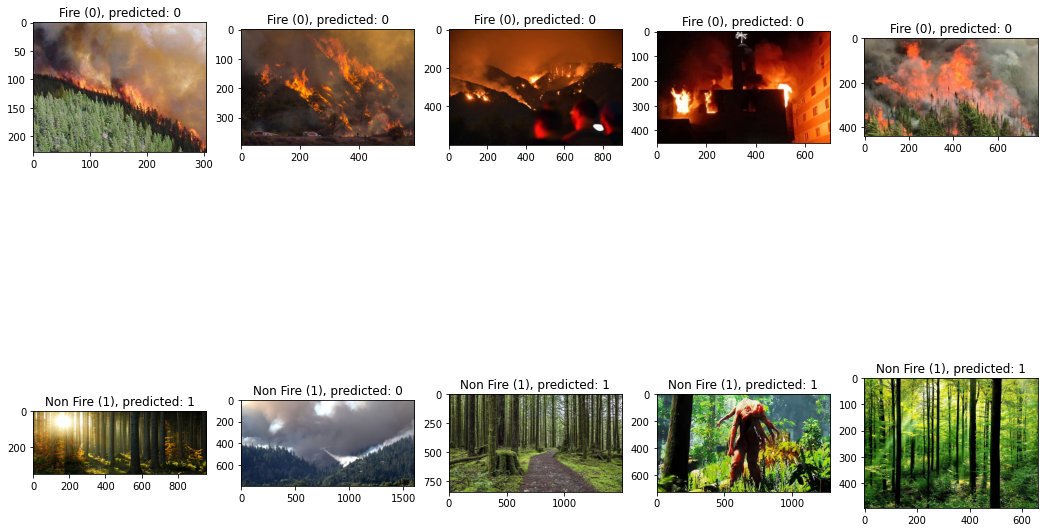

In [220]:
# Testing 5 random samples from each val folder 

random_fire = random.sample(val_fire, 5)
random_non_fire = random.sample(val_non_fire, 5)

fig, ax = plt.subplots(2,5, figsize=(18,12))
for i, u in enumerate(zip(random_fire, random_non_fire)):
    ax[0,i].set_title('Fire (0), predicted: {}'.format(img_to_input("fire_dataset_split/val/fire_images/{}".format(u[0]), predictor)))
    ax[0, i].imshow(np.asarray(Image.open("fire_dataset_split/val/fire_images/{}".format(u[0]))))
    ax[1,i].set_title('Non Fire (1), predicted: {}'.format(img_to_input("fire_dataset_split/val/non_fire_images/{}".format(u[1]), predictor)))
    ax[1, i].imshow(np.asarray(Image.open("fire_dataset_split/val/non_fire_images/{}".format(u[1]))))

In [222]:
# Test results

test_true_label = []
test_pred_label = []

for i, u in enumerate(test_fire):
    test_true_label.append(0)
    test_pred_label.append(img_to_input("fire_dataset_split/test/fire_images/{}".format(u), predictor))
for i, u in enumerate(test_non_fire):
    test_true_label.append(1)
    test_pred_label.append(img_to_input("fire_dataset_split/test/non_fire_images/{}".format(u), predictor))
    
acc = 100*np.sum((np.array(test_pred_label) == np.array(test_true_label)))/len(test_pred_label)

In [223]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('Test accuracy: ', accuracy_score(test_true_label, test_pred_label))
print('\nConfusion Matrix: \n', confusion_matrix(test_true_label, test_pred_label))
print('\nClassification Report: \n', classification_report(test_true_label, test_pred_label))

Test accuracy:  0.9803921568627451

Confusion Matrix: 
 [[76  0]
 [ 2 24]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        76
           1       1.00      0.92      0.96        26

    accuracy                           0.98       102
   macro avg       0.99      0.96      0.97       102
weighted avg       0.98      0.98      0.98       102



The model classes are 0 for fire and 1 for non fire, we can see from the classification reports that our model are scoring correctly all the fire images but mistaken some of the non fire images. That is the best scenario possible cause in the real life it's better to analyze some of the fire images to verify if their are wrong than let fire images pass trough our model.

Our first objective was to get more than 95% of accuracy, we already have 98% with a simple model!

Let's see if we can improve using other techniques.

In [214]:
# Seeying the name of endpoint
predictor.endpoint

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'tensorflow-training-2021-04-13-12-31-00-867'

In [ ]:
predictor.delete_endpoint()

### Improve the model using Transfer Learning

Our first training generated a relative good model, capable to identify all the fire photos, but mistaken some of the non fire photos. Now i will try to improve the overall accuracy of the model usign the transfer learning technique. 

In [225]:
tf_version = tf.__version__
tf_version

estimator = TensorFlow(
  entry_point="train_tf.py",    # My entry script
  role=role,
  train_instance_count=1, # "The number of GPUs instances to use"
  train_instance_type='ml.p2.xlarge',  
  framework_version=tf_version,
  py_version="py3",
  script_mode = True,
  hyperparameters={'epochs': 30}
)

print("Training ...")
estimator.fit({'train': train_input_path, 'eval': validation_input_path})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Training ...
2021-04-13 12:52:54 Starting - Starting the training job...
2021-04-13 12:53:18 Starting - Launching requested ML instancesProfilerReport-1618318373: InProgress
......
2021-04-13 12:54:18 Starting - Preparing the instances for training.........
2021-04-13 12:55:52 Downloading - Downloading input data......
2021-04-13 12:56:39 Training - Downloading the training image...
2021-04-13 12:57:19 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-04-13 12:57:18,385 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-04-13 12:57:18,891 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
  

In [226]:
predictor2 = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

In [230]:
# Test results

test_true_label = []
test_pred_label = []

for i, u in enumerate(test_fire):
    test_true_label.append(0)
    test_pred_label.append(img_to_input("fire_dataset_split/test/fire_images/{}".format(u), predictor2))
for i, u in enumerate(test_non_fire):
    test_true_label.append(1)
    test_pred_label.append(img_to_input("fire_dataset_split/test/non_fire_images/{}".format(u), predictor2))
    
acc = 100*np.sum((np.array(test_pred_label) == np.array(test_true_label)))/len(test_pred_label)

In [231]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('\nTest accuracy: ', accuracy_score(test_true_label, test_pred_label))
print('\nTest Confusion Matrix: \n', confusion_matrix(test_true_label, test_pred_label))
print('\nTest Classification Report: \n', classification_report(test_true_label, test_pred_label))


Test accuracy:  0.9411764705882353

Test Confusion Matrix: 
 [[72  4]
 [ 2 24]]

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        76
           1       0.86      0.92      0.89        26

    accuracy                           0.94       102
   macro avg       0.92      0.94      0.92       102
weighted avg       0.94      0.94      0.94       102



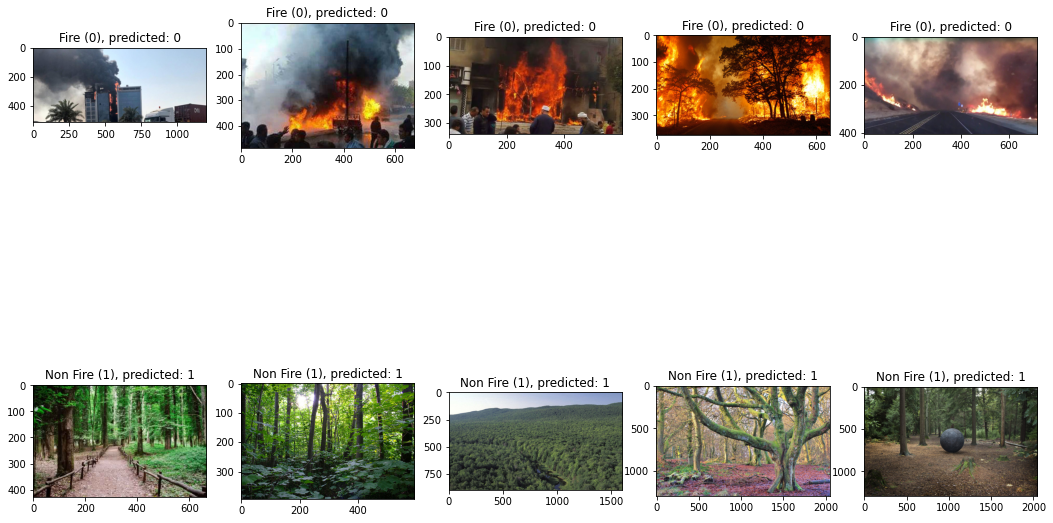

In [235]:
# Testing n random samples from each TEST folder 

n = 5
random_fire = random.sample(test_fire, n)
random_non_fire = random.sample(test_non_fire, n)

fig, ax = plt.subplots(2,n, figsize=(18,12))
for i, u in enumerate(zip(random_fire, random_non_fire)):
    ax[0,i].set_title('Fire (0), predicted: {}'.format(img_to_input("fire_dataset_split/test/fire_images/{}".format(u[0]), predictor2)))
    ax[0, i].imshow(np.asarray(Image.open("fire_dataset_split/test/fire_images/{}".format(u[0]))))
    ax[1,i].set_title('Non Fire (1), predicted: {}'.format(img_to_input("fire_dataset_split/test/non_fire_images/{}".format(u[1]), predictor2)))
    ax[1, i].imshow(np.asarray(Image.open("fire_dataset_split/test/non_fire_images/{}".format(u[1]))))

predictor2.delete_endpoint()

### Improve the model using Transfer Learning + Data Augmentation Techniques

We already used some augmentation, but now let's try to improve the overall accuracy using more techniques with rotation, shift ranges, flips and brightness manipulation! Let's try to increase the batch size too.

In [237]:
tf_version = tf.__version__
tf_version

estimator = TensorFlow(
  entry_point="train_tf_augmentation.py",    # My entry script
  role=role,
  train_instance_count=1, # "The number of GPUs instances to use"
  train_instance_type='ml.p2.xlarge',  
  framework_version=tf_version,
  py_version="py3",
  script_mode = True,
  hyperparameters={'epochs': 50, 'batch_size': 128}
)

print("Training ...")
estimator.fit({'train': train_input_path, 'eval': validation_input_path})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Training ...
2021-04-13 13:28:56 Starting - Starting the training job...
2021-04-13 13:28:57 Starting - Launching requested ML instancesProfilerReport-1618320535: InProgress
......
2021-04-13 13:30:25 Starting - Preparing the instances for training.........
2021-04-13 13:31:52 Downloading - Downloading input data......
2021-04-13 13:32:46 Training - Downloading the training image...
2021-04-13 13:33:28 Training - Training image download completed. Training in progress...WARNING:tensorflow:From /usr/local/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-04-13 13:33:33,615 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-04-13 13:33:34,256 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
 

In [246]:
predictor3 = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

In [247]:
# Test results

test_true_label = []
test_pred_label = []

for i, u in enumerate(test_fire):
    test_true_label.append(0)
    test_pred_label.append(img_to_input("fire_dataset_split/test/fire_images/{}".format(u), predictor3))
for i, u in enumerate(test_non_fire):
    test_true_label.append(1)
    test_pred_label.append(img_to_input("fire_dataset_split/test/non_fire_images/{}".format(u), predictor3))
    
total_acc = 100*np.sum((np.array(test_pred_label) == np.array(test_true_label)))/len(test_pred_label)
print('Overall Accuracy: ', total_acc)

Overall Accuracy:  75.49019607843137


In [248]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('\nTest accuracy: ', accuracy_score(test_true_label, test_pred_label))
print('\nTest Confusion Matrix: \n', confusion_matrix(test_true_label, test_pred_label))
print('\nTest Classification Report: \n', classification_report(test_true_label, test_pred_label))


Test accuracy:  0.7549019607843137

Test Confusion Matrix: 
 [[52 24]
 [ 1 25]]

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.68      0.81        76
           1       0.51      0.96      0.67        26

    accuracy                           0.75       102
   macro avg       0.75      0.82      0.74       102
weighted avg       0.86      0.75      0.77       102



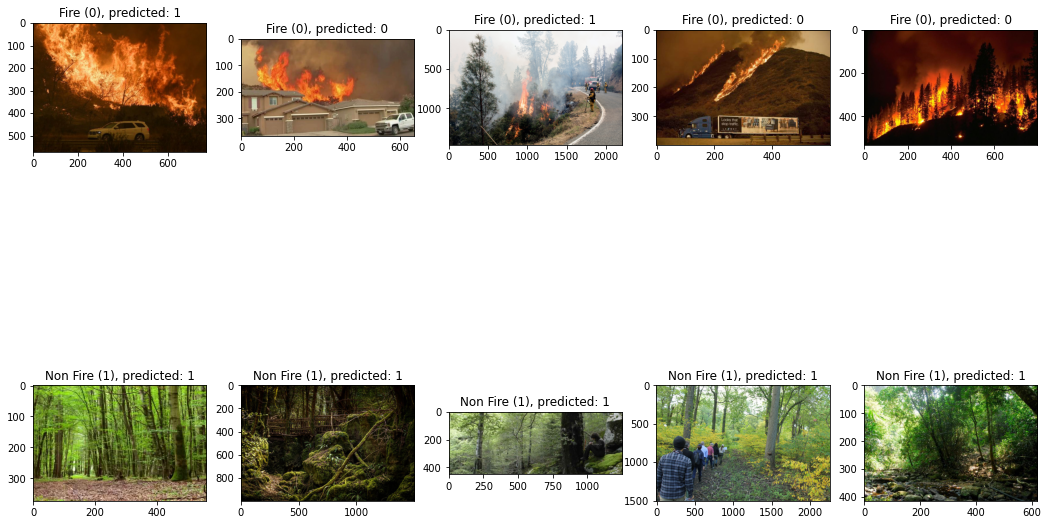

In [249]:
# Testing n random samples from each TEST folder 

n = 5
random_fire = random.sample(test_fire, n)
random_non_fire = random.sample(test_non_fire, n)

fig, ax = plt.subplots(2,n, figsize=(18,12))
for i, u in enumerate(zip(random_fire, random_non_fire)):
    ax[0,i].set_title('Fire (0), predicted: {}'.format(img_to_input("fire_dataset_split/test/fire_images/{}".format(u[0]),predictor3)))
    ax[0, i].imshow(np.asarray(Image.open("fire_dataset_split/test/fire_images/{}".format(u[0]))))
    ax[1,i].set_title('Non Fire (1), predicted: {}'.format(img_to_input("fire_dataset_split/test/non_fire_images/{}".format(u[1]),predictor3)))
    ax[1, i].imshow(np.asarray(Image.open("fire_dataset_split/test/non_fire_images/{}".format(u[1]))))

predictor3.delete_endpoint()